In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import  Dropout, Reshape
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.models import Model

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_test_ = y_test
print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))
print(x_train.shape)
print(x_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
Train Set Size = 60000 images
Test Set Size = 10000 images
(60000, 28, 28)
(10000, 28, 28)


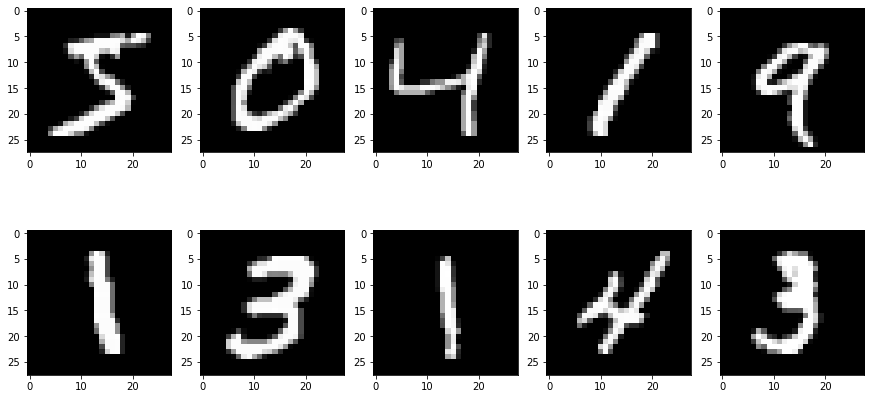

Labels : [5 0 4 1 9]
Labels : [1 3 1 4 3]


In [5]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [6]:
print(x_train.shape)
print(x_test.shape)

# expand new axis, channel axis 
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# it's always better to normalize 
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


# resize the input shape , i.e. old shape: 28, new shape: 32
x_train = tf.image.resize(x_train, [32,32]) # if we want to resize 
x_test = tf.image.resize(x_test, [32,32]) # if we want to resize 

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000, 32, 32, 1)
(10000, 32, 32, 1)


In [7]:
def reshaping(x):
  return np.reshape(x,(32,32))

a = list((map(reshaping,x_train)))
x_train = np.array(a)

b = list((map(reshaping,x_test)))
x_test = np.array(b)

print(x_train.shape)
print(x_test.shape)


(60000, 32, 32)
(10000, 32, 32)


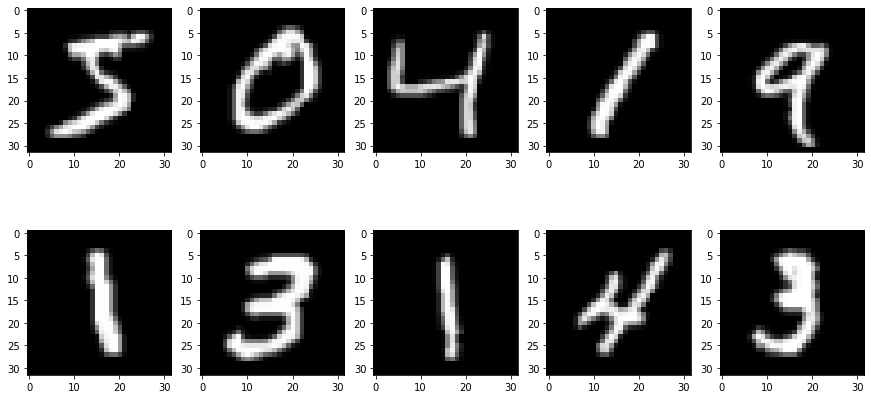

Labels : [5 0 4 1 9]
Labels : [1 3 1 4 3]


In [8]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [9]:
from  keras.utils import np_utils
y_train = to_categorical(y_train, num_classes=10, dtype='float32')
y_test = to_categorical(y_test, num_classes=10, dtype='float32')

print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))

Train Set Size = 60000 images
Test Set Size = 10000 images


In [13]:
optimizer = 'adam'
objective = 'categorical_crossentropy'

def two_conv_pool(x, F1, F2, name):
    x = Conv2D(F1, (3, 3), activation=None, padding='same', name='{}_conv1'.format(name))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(F2, (3, 3), activation=None, padding='same', name='{}_conv2'.format(name))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='{}_pool'.format(name))(x)

    return x

def three_conv_pool(x, F1, F2, F3, name):
        x = Conv2D(F1, (3, 3), activation=None, padding='same', name='{}_conv1'.format(name))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(F2, (3, 3), activation=None, padding='same', name='{}_conv2'.format(name))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(F3, (3, 3), activation=None, padding='same', name='{}_conv3'.format(name))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='{}_pool'.format(name))(x)

        return x

def vggModel():
        # Define the input as a tensor with shape input_shape
        X_input = Input((32,32,1))
        net = X_input

        net = two_conv_pool(net, 64, 64, "block1")
        net = two_conv_pool(net, 128, 128, "block2")
        net = three_conv_pool(net, 256, 256, 256, "block3")
        net = three_conv_pool(net, 512, 512, 512, "block4")
        #net = three_conv_pool(net, 512, 512, 512, "block5")

        net = Dropout(rate=.2)(net)
        net = Flatten()(net)
        net = Dropout(rate=.5)(net)
        net = Dense(2048, activation='relu', name='fc1')(net)
        net = Dropout(rate=.2)(net)
        net = Dense(1024, activation='relu', name='fc2')(net)
        net = Dropout(rate=.2)(net)
        net = Dense(512, activation='relu', name='fc3')(net)
        net = Dropout(rate=.2)(net)
        net = Dense(10, activation='softmax', name='predictions')(net)

        # Create model
        model = Model(inputs = X_input, outputs = net, name='vgg16')
        model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])
    
        return model

In [14]:
model = vggModel()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_11 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                            

In [15]:
batch_size = 64
num_epoch = 200

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('/content/drive/MyDrive/model/vgg16_model_test6.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

#model training
ret = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          #validation_split=0.25,
          validation_data=(x_test, y_test),
          callbacks=[es, mc])

Epoch 1/200
938/938 [==============================] - 84s 78ms/step - loss: 0.4018 - accuracy: 0.8721 - val_loss: 1.6486 - val_accuracy: 0.7526
Epoch 2/200
938/938 [==============================] - 74s 79ms/step - loss: 0.0882 - accuracy: 0.9799 - val_loss: 0.0929 - val_accuracy: 0.9792
Epoch 3/200
938/938 [==============================] - 74s 79ms/step - loss: 0.0746 - accuracy: 0.9837 - val_loss: 0.1005 - val_accuracy: 0.9799
Epoch 4/200
938/938 [==============================] - 72s 76ms/step - loss: 0.0654 - accuracy: 0.9857 - val_loss: 0.0667 - val_accuracy: 0.9825
Epoch 5/200
938/938 [==============================] - 71s 76ms/step - loss: 0.0636 - accuracy: 0.9869 - val_loss: 0.0438 - val_accuracy: 0.9909
Epoch 6/200
938/938 [==============================] - 70s 74ms/step - loss: 0.0593 - accuracy: 0.9877 - val_loss: 0.0461 - val_accuracy: 0.9909
Epoch 7/200
938/938 [==============================] - 70s 75ms/step - loss: 0.0600 - accuracy: 0.9881 - val_loss: 0.0585 - val_ac

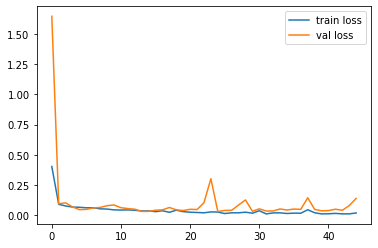

In [16]:
plt.plot(ret.history['loss'], label='train loss')
plt.plot(ret.history['val_loss'], label='val loss')
plt.legend()
plt.show()

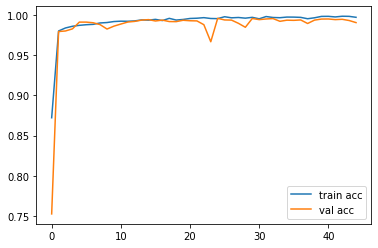

In [17]:
plt.plot(ret.history['accuracy'], label='train acc')
plt.plot(ret.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [18]:
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train accuracy: %.3f, Test accuracy: %.3f' % (train_acc, test_acc))

Train accuracy: 0.995, Test accuracy: 0.990


In [19]:
predictions = model.predict(x_test.reshape((-1,32,32,1)), verbose=0)

In [20]:
def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test_[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [21]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 99.03 %


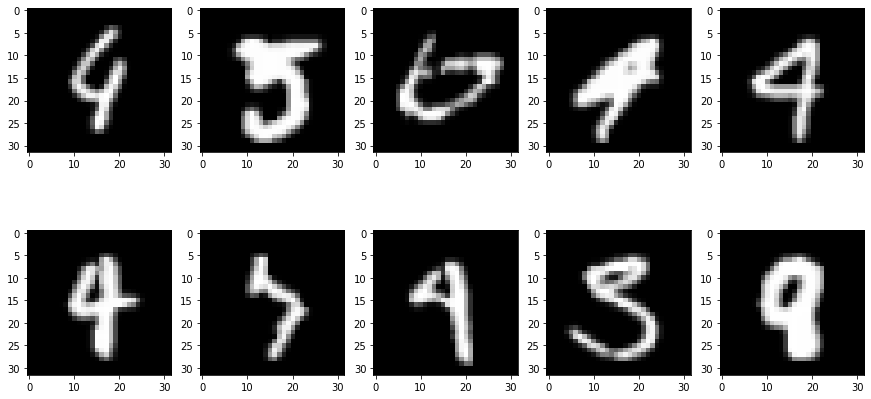

True:          [4 5 6 4 4]
classified as: [9 3 0 9 9]
True:          [4 7 4 3 8]
classified as: [9 3 9 5 9]


In [22]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test_[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test_[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))